In [1]:
from imutils import paths
from tqdm import tqdm
import numpy as np
import cv2
import gc
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
# Load the TensorBoard notebook extension
from keras.callbacks import TensorBoard
%load_ext tensorboard
import tensorflow as tf
import datetime, os
from keras.callbacks import EarlyStopping

from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


In [2]:
def IoU(y_val, y_pred):
    class_iou = []
    n_classes = 8
    
    y_predi = np.argmax(y_pred, axis=3)
    y_truei = np.argmax(y_val, axis=3)
    
    for c in range(n_classes):
        TP = np.sum((y_truei == c) & (y_predi == c))
        FP = np.sum((y_truei != c) & (y_predi == c))
        FN = np.sum((y_truei == c) & (y_predi != c)) 
        IoU = TP / float(TP + FP + FN)
        if(float(TP + FP + FN) == 0):
          IoU=TP/0.001
        class_iou.append(IoU)
    MIoU=sum(class_iou)/n_classes
    return MIoU
def miou( y_true, y_pred ) :
    score = tf.py_function( lambda y_true, y_pred : IoU( y_true, y_pred).astype('float32'),
                        [y_true, y_pred],
                        'float32')
    return score

In [3]:
dependencies = {
    'miou': miou
}
from keras.models import load_model
model = load_model('Unet_Resnet.hdf5', custom_objects=dependencies)

In [4]:
#x_path = paths.list_images("C:/Users/Kashif/Desktop/IDD/ANUE/idd20kII/leftImg8bit/test")
x_path = []
rootdir = 'C:/Users/Kashif/Desktop/IDD/ANUE/idd20kII/leftImg8bit/val'
for root, dirs, files in os.walk(rootdir):
    for name in files:
        if name.endswith((".jpg")):
            x_path.append(os.path.join(root, name).replace('\\','/'))

x_path.sort()            
len(x_path)         

1055

In [6]:
#x_path = paths.list_images("C:/Users/Kashif/Desktop/IDD/ANUE/idd20kII/leftImg8bit/test")
x_val = []
rootdir = 'C:/Users/Kashif/Desktop/IDD/ANUE/Val_Label/'
for root, dirs, files in os.walk(rootdir):
    for name in files:
        if name.endswith((".png")):
            x_val.append(os.path.join(root, name).replace('\\','/'))

x_val.sort()            
len(x_val)         

1055

In [15]:
image = cv2.imread(x_val[0],cv2.IMREAD_GRAYSCALE)
image.shape

(1080, 1920)

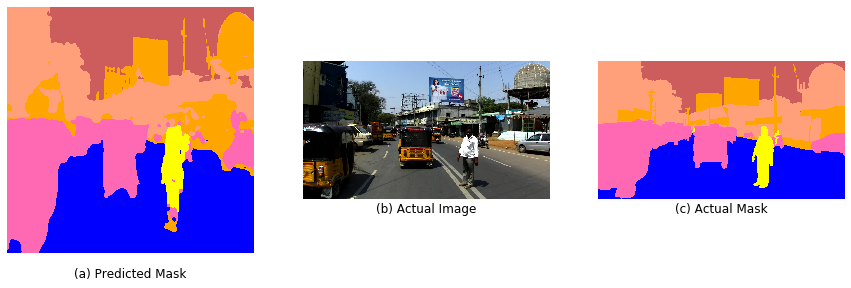

100%|████████████████████████████████████████████████████████████████████████████| 1055/1055 [1:33:49<00:00,  5.34s/it]

Write to:C:/Users/Kashif/Desktop/IDD/ANUE/Unet_Resnet/frame1054.jpg


In [37]:
from PIL import Image
from IPython.display import clear_output
for test_img in tqdm(range(len(x_path))):
    clear_output(wait=True)
    image = cv2.imread(x_path[test_img])
    img = cv2.resize(image, (256, 256))
    img = np.float32(img)  / 255 

    image = np.array(img)
    result = model.predict(np.expand_dims(image,axis = 0))
    result = np.argmax(result, axis=3)
    colors = np.array([
    [255, 192 ,203],      
    [255, 160, 122],     
    [255, 105, 180],      
    [205,  92,  92],        
    [255, 165,   0],    
    [255, 255,   0],      
    [165,  42,  42],     
    [0,   0, 255]           
  ], dtype=np.int)
    color_image = np.zeros(
          (result.shape[1], result.shape[2], 3), dtype=np.int)
    
    val_image = cv2.imread(x_val[test_img],cv2.IMREAD_GRAYSCALE) + 1
    color_image_val = np.zeros((val_image.shape[0], val_image.shape[1], 3), dtype=np.int) 
    
    for i in range(8):
        color_image[result[0] == i] = colors[i]
        color_image_val[val_image == i] = colors[i]
    from matplotlib import image
    from matplotlib import pyplot
    #pyplot.figure(figsize=(30, 30))
    fig, (ax0, ax1,ax2) = pyplot.subplots(ncols=3,figsize=(15,15))
    
    #ax0.figure(figsize=(10, 10))
    ax0.axis('off')
    ax0.imshow(color_image)
    import matplotlib.image as mpimg
    #ax1.figure(figsize=(10, 10))
    ax1.axis('off')
    ax1.imshow(mpimg.imread(x_path[test_img]))
    
    ax2.axis('off')
    ax2.imshow(color_image_val)
    
    ax0.text(0.5,-0.1, "(a) Predicted Mask", size=12, ha="center", 
         transform=ax0.transAxes)
    ax1.text(0.5,-0.1, "(b) Actual Image", size=12, ha="center", 
         transform=ax1.transAxes)
    ax2.text(0.5,-0.1, "(c) Actual Mask", size=12, ha="center", 
         transform=ax2.transAxes)
    
    pyplot.savefig('C:/Users/Kashif/Desktop/IDD/ANUE/Unet_Resnet/'+'frame'+ str(test_img)+'.jpg')
    pyplot.show()
    print("Write to:"+'C:/Users/Kashif/Desktop/IDD/ANUE/Unet_Resnet/'+'frame'+ str(test_img)+'.jpg')


In [40]:
!ffmpeg -r 2 -i "C:\Users\Kashif\Desktop\IDD\ANUE\Unet_Resnet\frame%01d.jpg"  -vcodec mpeg4 -y unet_resnet.mp4

ffmpeg version git-2020-06-08-d29aaf1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 9.3.1 (GCC) 20200523
  configuration: --enable-gpl --enable-version3 --enable-sdl2 --enable-fontconfig --enable-gnutls --enable-iconv --enable-libass --enable-libdav1d --enable-libbluray --enable-libfreetype --enable-libmp3lame --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libopus --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libsrt --enable-libtheora --enable-libtwolame --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libzimg --enable-lzma --enable-zlib --enable-gmp --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvo-amrwbenc --enable-libmysofa --enable-libspeex --enable-libxvid --enable-libaom --disable-w32threads --enable-libmfx --enable-ffnvcodec --enable-cuda-llvm --enable-cuvid --enable-d3d11va --enable-nvenc --enable-nvdec --enable-dxva2 --enab

In [41]:
dependencies = {
    'miou': miou
}
from keras.models import load_model
model = load_model('CANet.hdf5', custom_objects=dependencies)

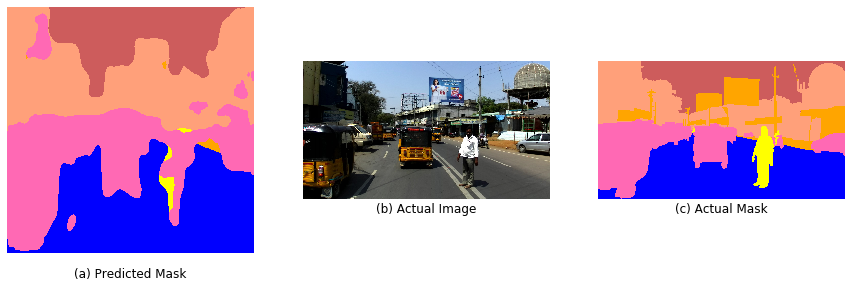

100%|████████████████████████████████████████████████████████████████████████████| 1055/1055 [1:34:20<00:00, 93.20s/it]

Write to:C:/Users/Kashif/Desktop/IDD/ANUE/CANET/frame1054.jpg


100%|████████████████████████████████████████████████████████████████████████████| 1055/1055 [1:34:23<00:00,  5.37s/it]


In [43]:
from PIL import Image
from IPython.display import clear_output
for test_img in tqdm(range(len(x_path))):
    clear_output(wait=True)
    image = cv2.imread(x_path[test_img])
    img = cv2.resize(image, (512, 512))
    img = np.float32(img)  / 255 

    image = np.array(img)
    result = model.predict(np.expand_dims(image,axis = 0))
    result = np.argmax(result, axis=3)
    colors = np.array([
    [255, 192 ,203],      
    [255, 160, 122],     
    [255, 105, 180],      
    [205,  92,  92],        
    [255, 165,   0],    
    [255, 255,   0],      
    [165,  42,  42],     
    [0,   0, 255]           
  ], dtype=np.int)
    color_image = np.zeros(
          (result.shape[1], result.shape[2], 3), dtype=np.int)
    
    val_image = cv2.imread(x_val[test_img],cv2.IMREAD_GRAYSCALE) + 1
    color_image_val = np.zeros((val_image.shape[0], val_image.shape[1], 3), dtype=np.int) 
    
    for i in range(8):
        color_image[result[0] == i] = colors[i]
        color_image_val[val_image == i] = colors[i]
    from matplotlib import image
    from matplotlib import pyplot
    #pyplot.figure(figsize=(30, 30))
    fig, (ax0, ax1,ax2) = pyplot.subplots(ncols=3,figsize=(15,15))
    
    #ax0.figure(figsize=(10, 10))
    ax0.axis('off')
    ax0.imshow(color_image)
    import matplotlib.image as mpimg
    #ax1.figure(figsize=(10, 10))
    ax1.axis('off')
    ax1.imshow(mpimg.imread(x_path[test_img]))
    
    ax2.axis('off')
    ax2.imshow(color_image_val)
    
    ax0.text(0.5,-0.1, "(a) Predicted Mask", size=12, ha="center", 
         transform=ax0.transAxes)
    ax1.text(0.5,-0.1, "(b) Actual Image", size=12, ha="center", 
         transform=ax1.transAxes)
    ax2.text(0.5,-0.1, "(c) Actual Mask", size=12, ha="center", 
         transform=ax2.transAxes)
    
    pyplot.savefig('C:/Users/Kashif/Desktop/IDD/ANUE/CANET/'+'frame'+ str(test_img)+'.jpg')
    pyplot.show()
    print("Write to:"+'C:/Users/Kashif/Desktop/IDD/ANUE/CANET/'+'frame'+ str(test_img)+'.jpg')


In [44]:
!ffmpeg -r 2 -i "C:\Users\Kashif\Desktop\IDD\ANUE\CANET\frame%01d.jpg"  -vcodec mpeg4 -y CANET.mp4

ffmpeg version git-2020-06-08-d29aaf1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 9.3.1 (GCC) 20200523
  configuration: --enable-gpl --enable-version3 --enable-sdl2 --enable-fontconfig --enable-gnutls --enable-iconv --enable-libass --enable-libdav1d --enable-libbluray --enable-libfreetype --enable-libmp3lame --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libopus --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libsrt --enable-libtheora --enable-libtwolame --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libzimg --enable-lzma --enable-zlib --enable-gmp --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvo-amrwbenc --enable-libmysofa --enable-libspeex --enable-libxvid --enable-libaom --disable-w32threads --enable-libmfx --enable-ffnvcodec --enable-cuda-llvm --enable-cuvid --enable-d3d11va --enable-nvenc --enable-nvdec --enable-dxva2 --enab

frame=  389 fps=6.1 q=20.4 size=    4864kB time=00:03:14.00 bitrate= 205.4kbits/s speed=3.06x    
frame=  393 fps=6.1 q=17.3 size=    4864kB time=00:03:16.00 bitrate= 203.3kbits/s speed=3.05x    
frame=  397 fps=6.1 q=15.7 size=    4864kB time=00:03:18.00 bitrate= 201.2kbits/s speed=3.06x    
frame=  401 fps=6.1 q=17.0 size=    4864kB time=00:03:20.00 bitrate= 199.2kbits/s speed=3.06x    
frame=  403 fps=6.1 q=15.2 size=    4864kB time=00:03:21.00 bitrate= 198.2kbits/s speed=3.05x    
frame=  406 fps=6.1 q=21.9 size=    5120kB time=00:03:22.50 bitrate= 207.1kbits/s speed=3.04x    
frame=  410 fps=6.1 q=18.9 size=    5120kB time=00:03:24.50 bitrate= 205.1kbits/s speed=3.05x    
frame=  413 fps=6.1 q=18.2 size=    5120kB time=00:03:26.00 bitrate= 203.6kbits/s speed=3.04x    
frame=  416 fps=6.1 q=15.6 size=    5120kB time=00:03:27.50 bitrate= 202.1kbits/s speed=3.02x    
frame=  419 fps=6.0 q=21.6 size=    5120kB time=00:03:29.00 bitrate= 200.7kbits/s speed=   3x    
frame=  421 fps=6.0 

frame=  750 fps=4.8 q=14.7 size=    9216kB time=00:06:14.50 bitrate= 201.6kbits/s speed=2.41x    
frame=  753 fps=4.8 q=19.7 size=    9216kB time=00:06:16.00 bitrate= 200.8kbits/s speed=2.41x    
frame=  756 fps=4.8 q=20.7 size=    9216kB time=00:06:17.50 bitrate= 200.0kbits/s speed=2.41x    
frame=  759 fps=4.8 q=18.7 size=    9216kB time=00:06:19.00 bitrate= 199.2kbits/s speed= 2.4x    
frame=  763 fps=4.8 q=15.4 size=    9472kB time=00:06:21.00 bitrate= 203.7kbits/s speed=2.41x    
frame=  767 fps=4.8 q=20.9 size=    9472kB time=00:06:23.00 bitrate= 202.6kbits/s speed=2.41x    
frame=  771 fps=4.8 q=19.8 size=    9472kB time=00:06:25.00 bitrate= 201.5kbits/s speed=2.42x    
frame=  775 fps=4.8 q=16.2 size=    9472kB time=00:06:27.00 bitrate= 200.5kbits/s speed=2.42x    
frame=  780 fps=4.9 q=21.3 size=    9472kB time=00:06:29.50 bitrate= 199.2kbits/s speed=2.43x    
frame=  785 fps=4.9 q=18.7 size=    9728kB time=00:06:32.00 bitrate= 203.3kbits/s speed=2.43x    
frame=  790 fps=4.9 